In [1]:
import functools
import requests
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# RUNNING THIS CELL RESETS THE CACHE

@functools.lru_cache(maxsize=512)
def cached_get(url):
    time.sleep(.5) # used to rate limit the api call, sleep is skipped when cached
    return requests.get(url)

In [159]:
SERVER = 'earthfury-alliance'

def api(item, timerange=7):
    url = f'https://api.nexushub.co/wow-classic/v1/items/{SERVER}/{item}/prices?timerange={timerange}'
    return cached_get(url).json()

**Basic GET functions**

In [183]:
def get_name(item):
    return api(item)['name']

def get_data(item):
    return api(item)['data']

def get_dataframe(item):
    df = pd.DataFrame(get_data(item))
    df['scannedAt'] = pd.to_datetime(df['scannedAt'])
    df['marketValue'] /= 100
    df['minBuyout']   /= 100
    df['minBuyoutPercentile'] = df['minBuyout'].rank(pct=True)
    return df

def get_current_dbmarket(item):
    return get_dataframe(item)['marketValue'].iloc[-1]

def get_current_volume(item):
    return get_dataframe(item)['quantity'].iloc[-1]

def get_minBuyout_at_pctile(item, pctile):
    arr = get_dataframe(item)['minBuyout'].to_list()
    return np.percentile(arr, pctile*100)

**Basic PLOT functions**

In [106]:
def plot_minBuyout(item):
    get_dataframe(item).plot(x='scannedAt', y='minBuyout')
    
def plot_dbmarket(item):
    get_dataframe(item).plot(x='scannedAt', y='marketValue')

**FLIP functions**

In [196]:
# RUNNING THIS CELL RESETS THE CACHE

@functools.lru_cache(maxsize=512)
def get_flip_count(item, buy_pctile, profit=.15):
    df = get_dataframe(item)
    count = 0
    buysell = 'buy'    
    
    for pct, val in df[['minBuyoutPercentile','minBuyout']].to_numpy(): #apparently way faster than df.iterrows()
        # buy conditions
        if buysell=='buy' and pct < buy_pctile:
            price   = val
            buysell = 'sell'
        
        # sell conditions
        if buysell=='sell' and val > price*(1+profit):
            count += 1
            buysell = 'buy'    

    return count

In [197]:
def get_flip_profile(item):
    return [ (i/100, get_flip_count(item,i/100)) for i in range(0,100)]

def plot_flip_profile(item):
    x, y = zip(*get_flip_profile(item))
    label = get_name(item) + ' | auc:' + str(get_flip_profile_auc(item))
    plt.plot(x,y, label=label) 
    
def get_flip_profile_auc(item):
    x, y = zip(*get_flip_profile(item))
    return sum(y)/100 

def get_best_flip(item):
    return max(get_flip_profile(item), key=lambda x:x[1])[1]

def get_best_flip_pctile(item):
    # from profit_profile, get x when y is max
    return max(get_flip_profile(item), key=lambda x:x[1])[0]

def get_best_flip_price(item):
    # get minBuyout at best percentile
    return get_minBuyout_at_pctile(item, get_best_flip_pctile(item))

**FLIP PROFIT Function**

In [151]:
def get_profit_profile(item):
    profit = .1 # assume a 15% flip minus 5% auction cut
    return [(x, get_minBuyout_at_pctile(item,x) * profit * y) for x,y in get_flip_profile(item)] 

def plot_profit_profile(item):
    x, y = zip(*get_profit_profile(item))
    label = get_name(item) + ' | auc:' + str(get_profit_profile_auc(item))
    plt.plot(x,y, label=label) 

def get_profit_profile_auc(item):
    x, y = zip(*get_profit_profile(item))
    return sum(y)/100

def get_best_profit_pctile(item):
    # from profit_profile, get x when y is max
    return max(get_profit_profile(item), key=lambda x:x[1])[0]

def get_best_profit_price(item):
    # get minBuyout at best percentile
    return get_minBuyout_at_pctile(item, get_best_flip_pctile(item))

**TESTING**

CPU times: user 888 ms, sys: 79.4 ms, total: 968 ms
Wall time: 2.95 s


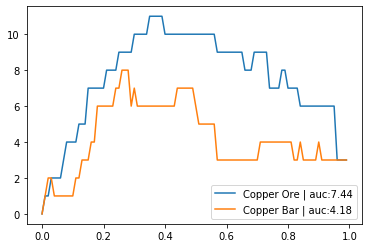

In [152]:
%%time
plot_flip_profile(2770)
plot_flip_profile(2840)
plt.legend()

CPU times: user 1.41 s, sys: 238 ms, total: 1.65 s
Wall time: 1.84 s


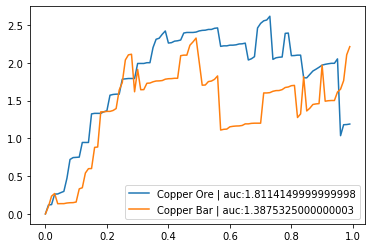

In [153]:
%%time
plot_profit_profile(2770)
plot_profit_profile(2840)
plt.legend()

### Same plots for Skeram

CPU times: user 1.64 s, sys: 8.08 ms, total: 1.65 s
Wall time: 1.65 s


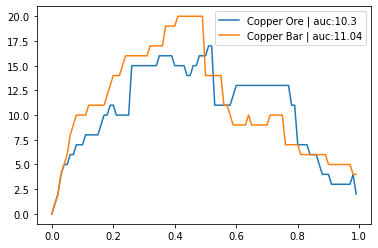

In [157]:
%%time
SERVER = 'skeram-horde' ## NOTE -- reset GET_FLIP_COUNT cache for server change to take effect
plot_flip_profile(2770)
plot_flip_profile(2840)
plt.legend()

CPU times: user 2.71 s, sys: 6.93 ms, total: 2.72 s
Wall time: 2.72 s


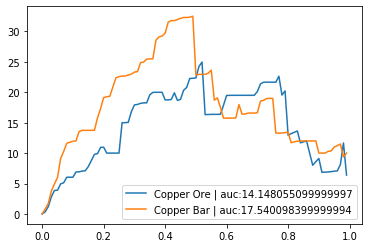

In [158]:
%%time
plot_profit_profile(2770)
plot_profit_profile(2840)
plt.legend()

### Big Pull

In [161]:
SERVER = 'earthfury-alliance' ## NOTE -- reset GET_FLIP_COUNT cache for server change to take effect

In [198]:
herbs   = [8153,8836,13468,13466,13465,8845,8831,3355,2453,3369,2447,765,3356,3358,4625,2450,3821,3818,8846,8838,3820,3819,8839,2452,2449,785,13467,3357,13463,13464]
cloth   = [2589,4306,4338,2592,14047,14256,14342,2996,2997,4305,4339,14048]
mining  = [2772,3340,2771,2775,2770,5833,3858,2776,10620,7911,11370,18562,12360,2842,3575,3859,2840,2841,6037,3577,3576,3860,12359,17771,11371,12655,3861]
enchant = [10940,11083,11137,11176,16204,10938,10939,10998,11082,11134,11135,11174,11175,16202,16203,10978,11084,11138,11139,11177,11178,14343,14344,20725]
everything = herbs + cloth + mining + enchant


results = []
error = []
for item in everything:
    if get_data(item) == []:
        error.append(item)
    else:
        name             = get_name(item)
        current_dbmarket = get_current_dbmarket(item)
        current_volume   = get_current_volume(item)
        flip_max         = get_best_flip(item)
        flip_auc         = get_flip_profile_auc(item)
        purchase_price   = get_best_flip_price(item)
        posting_price    = purchase_price*1.15

        result = (item, name, current_dbmarket, current_volume, flip_max, flip_auc, purchase_price, posting_price)
        results += [result]
        print(result, sep=', ') 

df = pd.DataFrame(results, columns=['item', 'name', 'current_dbmarket', 'current_volume', 'flip_max', 'flip_auc', 'purchase_price', 'posting_price'])

(8153, 'Wildvine', 137.83, 337, 12, 7.77, 100.0, 114.99999999999999)
(8836, "Arthas' Tears", 4.92, 157, 9, 5.49, 4.5172, 5.19478)
(13468, 'Black Lotus', 15762.76, 12, 1, 0.97, 15888.29, 18271.5335)
(13466, 'Plaguebloom', 217.99, 179, 9, 4.47, 185.214, 212.99609999999998)
(13465, 'Mountain Silversage', 159.12, 320, 8, 3.5, 118.6975, 136.502125)
(8845, 'Ghost Mushroom', 143.73, 148, 13, 8.21, 121.48360000000001, 139.70614)
(8831, 'Purple Lotus', 9.37, 385, 12, 7.02, 6.6, 7.589999999999999)
(3355, 'Wild Steelbloom', 51.14, 197, 8, 5.9, 47.0, 54.05)
(2453, 'Bruiseweed', 1.72, 111, 14, 8.46, 1.0775000000000001, 1.239125)
(3369, 'Grave Moss', 39.97, 165, 13, 6.32, 43.95, 50.5425)
(2447, 'Peacebloom', 0.17, 349, 7, 4.43, 0.18, 0.207)
(765, 'Silverleaf', 0.12, 592, 7, 4.77, 0.29, 0.33349999999999996)
(3356, 'Kingsblood', 6.75, 230, 16, 10.38, 4.252000000000001, 4.8898)
(3358, "Khadgar's Whisker", 6.15, 183, 12, 7.65, 5.45, 6.2675)
(4625, 'Firebloom', 25.65, 235, 19, 11.06, 27.9912, 32.18987999

In [201]:
df.sort_values(by='flip_auc', ascending=False).head(20)

,item,name,current_dbmarket,current_volume,flip_max,flip_auc,purchase_price,posting_price
20,3820,Stranglekelp,19.56,261,19,12.58,21.9852,25.282980
30,2589,Linen Cloth,0.83,1235,16,12.40,0.3968,0.456320
31,4306,Silk Cloth,2.13,3024,17,12.39,1.7680,2.033200
27,3357,Liferoot,9.50,137,20,12.07,10.8300,12.454500
14,4625,Firebloom,25.65,235,19,11.06,27.9912,32.189880
22,8839,Blindweed,100.00,240,17,10.70,61.9600,71.254000
12,3356,Kingsblood,6.75,230,16,10.38,4.2520,4.889800
15,2450,Briarthorn,2.99,581,14,10.33,2.6512,3.048880
19,8838,Sungrass,51.22,408,17,10.06,27.0050,31.055750
34,14047,Runecloth,11.00,394,12,9.49,6.3500,7.302500


In [208]:
df.loc[df['item'].isin(mining)].sort_values(by='flip_auc', ascending=False)

,item,name,current_dbmarket,current_volume,flip_max,flip_auc,purchase_price,posting_price
56,3575,Iron Bar,24.75,92,16,9.17,14.4500,16.617500
55,2842,Silver Bar,8.39,164,19,8.96,6.7528,7.765720
45,2775,Silver Ore,24.64,62,12,8.59,16.9007,19.435805
50,10620,Thorium Ore,20.76,224,11,7.96,18.0000,20.700000
46,2770,Copper Ore,1.90,1061,11,7.44,2.0000,2.300000
44,2771,Tin Ore,3.91,209,11,6.78,2.7850,3.202750
42,2772,Iron Ore,9.42,217,11,6.47,8.0000,9.200000
64,12359,Thorium Bar,16.80,1223,13,6.40,36.0000,41.400000
49,2776,Gold Ore,11.00,40,9,5.83,12.6900,14.593500
52,11370,Dark Iron Ore,26.17,228,9,5.60,27.0000,31.050000


### Single Item Deep Dive

In [209]:
item = 2770
get_name(item)

'Copper Ore'

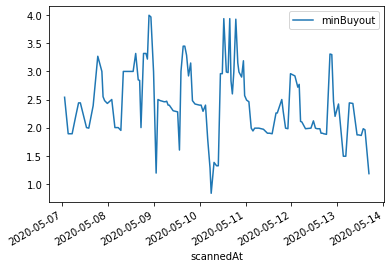

In [210]:
plot_minBuyout(item)


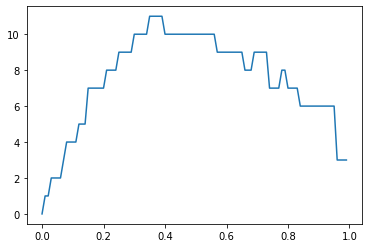

In [211]:
plot_flip_profile(item)

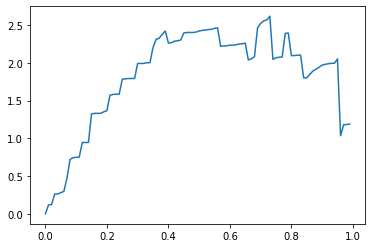

In [212]:
plot_profit_profile(item)

In [213]:
get_best_flip_pctile(item)

0.35

In [214]:
get_best_flip_price(item)

2.0

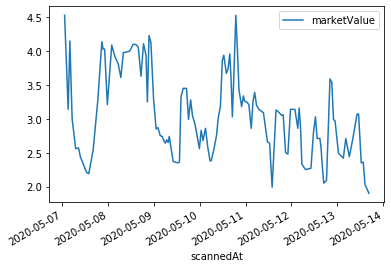

In [215]:
plot_dbmarket(item)